# Convert Caffe Pretrained AlexNet to `uml` Structure

In [1]:
%pylab inline
import sys
import os
import time
import warnings
sys.path.append("../../research/")
sys.path.append('../../3rdparty/caffe/python/')
HOME = os.path.expanduser('~')

warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import pandas
import theano
import theano.tensor as T
import seaborn
import caffe

from uml import layers
from uml import optimisation
from uml.models import SequentialModel

Using gpu device 2: Tesla K20c (CNMeM is disabled, cuDNN 5005)


## Purpose
This example demonstrates how to convert a network from [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) for use with `uml` deep learning library. [AlexNet model](http://dl.caffe.berkeleyvision.org/bvlc_alexnet.caffemodel) trained for
[LSVRC2012](http://image-net.org/challenges/LSVRC/2012/index). The notebook create a set of `uml` layers corresponding to the Caffe model specification (prototxt), then copy the parameters from the caffemodel file into our model.

**Data: 09th of May 2016**

### Download AlexNet model
Download [AlexNet model](http://dl.caffe.berkeleyvision.org/bvlc_alexnet.caffemodel) and place it in `caffe/models`

In [3]:
%%bash
if ! [ -f ../../3rdparty/caffe/models/bvlc_alexnet/bvlc_alexnet.caffemodel ]; then
    wget -c http://dl.caffe.berkeleyvision.org/bvlc_alexnet.caffemodel -P ../../3rdparty/caffe/models/bvlc_alexnet/
fi

In [4]:
%%bash
if ! [ -f ../files/ilsvrc12/synset_words.txt ]; then
    mkdir -p ../files/ilsvrc12
    if ! [ -f ../files/ilsvrc12/caffe_ilsvrc12.tar.gz ]; then
        wget -c http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz -P ../files/ilsvrc12/
    fi
    tar -zxf ../files/ilsvrc12/caffe_ilsvrc12.tar.gz -C ../files/ilsvrc12/
fi

In [5]:
classes, synwords = [], []
with open('../files/ilsvrc12/synset_words.txt', 'r') as synset:
    for line in synset:
        word, lbl = line.split(' ', 1)
        synwords.append(word)
        classes.append(lbl.rsplit('\n')[0])

In [6]:
classes.index('goose'), synwords[99]

(99, 'n01855672')

### Transfer AlexNet from [caffe](http://caffe.berkeleyvision.org/) to `uml`

In [7]:
proto_path = '../../3rdparty/caffe/models/bvlc_alexnet/deploy.prototxt'
model_path = '../../3rdparty/caffe/models/bvlc_alexnet/bvlc_alexnet.caffemodel'
net_caffe = caffe.Classifier(proto_path, model_path, caffe.TEST, mean=numpy.ones(3))

In [8]:
alex_net = SequentialModel()
alex_net.add(layers.InputLayer(shape=(None, 3, 227, 227)))
alex_net.add(layers.Conv2DLayer(size=96, filter_size=(11, 11), stride=(4, 4), activation='relu', name='conv1'))
alex_net.add(layers.LRN2DLayer(n=5, alpha=0.0001, name='norm1'))
alex_net.add(layers.MaxPool2DLayer(ds=(3, 3), stride=(2, 2), name='pool1'))
alex_net.add(layers.Pad2DLayer(pad_size=(2, 2), name='pad1'))
alex_net.add(layers.Conv2DLayer(size=256, group=2, mode='valid', filter_size=(5, 5), activation='relu', name='conv2'))
alex_net.add(layers.LRN2DLayer(n=5, alpha=0.0001, name='norm2'))
alex_net.add(layers.MaxPool2DLayer(ds=(3, 3), stride=(2, 2), name='pool2'))
alex_net.add(layers.Conv2DLayer(size=384, mode='same', filter_size=(3, 3), activation='relu', name='conv3'))
alex_net.add(layers.Conv2DLayer(size=384, group=2, mode='same', filter_size=(3, 3), activation='relu', name='conv4'))
alex_net.add(layers.Conv2DLayer(size=256, group=2, mode='same', filter_size=(3, 3), activation='relu', name='conv5'))
alex_net.add(layers.MaxPool2DLayer(ds=(3, 3), stride=(2, 2), name='pool5'))
alex_net.add(layers.FlattenLayer(name='flat1'))
alex_net.add(layers.HiddenLayer(size=4096, name='fc6', activation='relu'))
alex_net.add(layers.DropoutLayer(p=0.5, name='drop6'))
alex_net.add(layers.HiddenLayer(size=4096, name='fc7', activation='relu'))
alex_net.add(layers.DropoutLayer(p=0.5, name='drop7'))
alex_net.add(layers.OutputLayer(size=1000, name='fc8', activation='linear'))

alex_net.compile()

SequentialModel(name='SequentialModel', save_freq=1, save_path=None,
                seed=None, valid_freq=10, verbose=2)

In [9]:
alex_net.model_config(tablefmt='simple')

Name    Top    Type          Units #  Shape                  Data Mem (MB)  Params # (MB)
------  -----  ---------  ----------  -------------------  ---------------  ---------------------
Input   Input  Input      3.0000e+00  (None, 3, 227, 227)       6.1835e-01  0.0000e+00 (0.0000)
conv1   Input  Conv2D     9.6000e+01  (None, 96, 55, 55)        1.1616e+00  3.4944e+04 (0.1398)
norm1   conv1  LRN2D      9.6000e+01  (None, 96, 55, 55)        1.1616e+00  0.0000e+00 (0.0000)
pool1   norm1  MaxPool2D  9.6000e+01  (None, 96, 27, 27)        2.7994e-01  0.0000e+00 (0.0000)
pad1    pool1  Pad2D      9.6000e+01  (None, 96, 31, 31)        3.6902e-01  0.0000e+00 (0.0000)
conv2   pad1   Conv2D     2.5600e+02  (None, 256, 27, 27)       7.4650e-01  3.0746e+05 (1.2298)
norm2   conv2  LRN2D      2.5600e+02  (None, 256, 27, 27)       7.4650e-01  0.0000e+00 (0.0000)
pool2   norm2  MaxPool2D  2.5600e+02  (None, 256, 13, 13)       1.7306e-01  0.0000e+00 (0.0000)
conv3   pool2  Conv2D     3.8400e+02  (None,

In [10]:
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))
for layer in alex_net.layers:
    try:
        if 'fc' in layer.name:
            layer.W.set_value(layers_caffe[layer.name].blobs[0].data.T)
            layer.b.set_value(layers_caffe[layer.name].blobs[1].data)  
        else:
            layer.W.set_value(layers_caffe[layer.name].blobs[0].data[:, :, ::-1, ::-1])
            layer.b.set_value(layers_caffe[layer.name].blobs[1].data)          
    except AttributeError:
        continue

In [11]:
HOME = os.path.expanduser('~')
MODEL_PATH = HOME + '/data/uml/models/weights_alexnet.hdf5'
alex_net.save_params(MODEL_PATH, overwrite=True)

### Visualise AlexNet

In [12]:
from collections import OrderedDict
alexnet_layers = OrderedDict([(layer.name, layer) for layer in alex_net.layers])

In [13]:
from scipy import ndimage

def stitch_images_(x, spacing=1, save_path=None):
    """ Stitch images into one array

    Parameters
    ----------
    x: An {array-like} object
        A array of images to stitch together

    spacing: An int object
        The space between images in pixels

    save_path: A string object, optional
        Output file name or file object.

    Returns
    -------
    An {array-like} object containing the stitched images
    """
    shape = x[0].shape
    n = numpy.ceil(numpy.sqrt(x.shape[0])).astype('int')
    m = numpy.ceil(x.shape[0] / n).astype('int')

    width = m * shape[0] + (m - 1) * spacing
    height = n * shape[1] + (n - 1) * spacing

    im_shape = (width, height) + shape[2:]
    images = numpy.zeros(im_shape, dtype=x[0].dtype)

    i, j = 0, 0
    w, h = shape[:2]
    for img in x:
        d_w = (w + spacing) * j
        d_h = (h + spacing) * i

        if len(shape) == 2:  # gray scale image
            images[d_w: d_w + w, d_h: d_h + h] = img
        else:
            images[d_w: d_w + w, d_h: d_h + h, :] = img

        if i == n - 1:
            i, j = 0, j + 1
        else:
            i += 1

    if save_path is not None:
        imsave(save_path, images)

    return images


def show_filters(filters, name='', figsize=(13, 13), rotate=0, spacing=1):
    """ Dispalay activation maximisation filters
    
    Parameters
    ----------
    filters: An array object shape(n_samples, channel(default: 1), width, height)
        The activation maximisation filters to display
    
    name: A str object
        Figure title
        
    figsize : tuple of integers, optional, default: (13, 13)
        width, height of the figure in inches.

    Returns
    -------
    A matplotlib figure object
    """
    fig = figure(figsize=figsize)
    axis('off')
    title(name)
    if filters.shape[3] == 1:
        filters = filters.reshape(filters.shape[:-1])
        
    images = stitch_images_(filters, spacing=spacing)
    images = ndimage.rotate(images, rotate)
    imshow(images)
    
    return fig

#### Conv1 weights

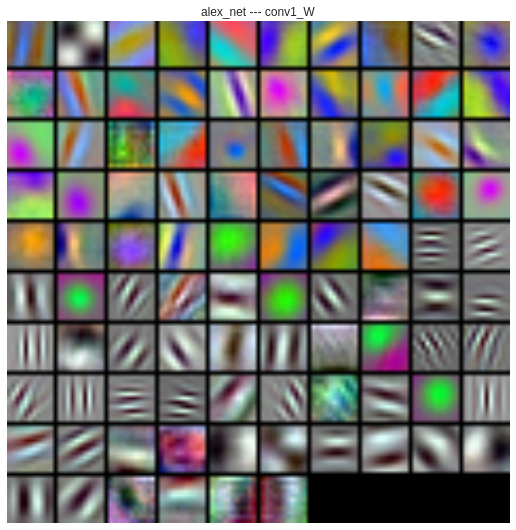

In [14]:
from uml.stats import visualise_conv_weights
fig, weights = visualise_conv_weights(alexnet_layers['conv1'], 'alex_net', figsize=(9, 9))

In [15]:
from cStringIO import StringIO

import PIL.Image
import numpy
import scipy.ndimage as nd
from IPython.display import Image, display
from sklearn.utils import check_random_state

from uml.stats.monitoring import Logger
from uml.utils.gen_utils import Params, handle_zeros

def showarray(a, f, fmt='jpeg'):
    a = numpy.uint8(numpy.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [16]:
import numpy
import scipy.ndimage as nd
import theano
import theano.tensor as T
from sklearn.utils import check_random_state
from skimage.restoration import denoise_tv_bregman

from uml.stats.monitoring import Logger
from uml.utils import l2_norm, l1_norm, scale, pad_tensor, normalise
from uml.utils.gen_utils import Params, handle_zeros
from uml.utils.image_utils import blur_images

def bound_range(x, alpha=6, B_plus=160, epsilon=1e-10):
    if x.ndim == 4:
        x_tmp = (T.sum(x, axis=1) *  T.sum(x, axis=1)) ** ( alpha/2.) 
        norm = l2_norm(x) * x.shape[-2] * x.shape[-1]
        out = T.sum(x_tmp) / T.switch( T.abs_(norm) <= epsilon, 1.0, norm)
        return out # T.switch(T.mean(T.sqrt(T.sum(x, axis=1) **2) <= B_plus) <=1., out, 1.0)
    else:
        return 0.0

    
def tv_norm(x, beta=1.5, value=0., B=80, epsilon=1e-10):    
    if x.ndim == 4:
        x_o1 = pad_tensor(x, 1, axis=2, pos='right')
        x_o2 = pad_tensor(x, 1, axis=3, pos='right')
        x1 = x_o1[:, :, 1:, :] - x
        x2 = x_o2[:, :, :, 1:] - x    
        out = T.pow(x1 ** 2 + x2 **2, beta/2.)
        norm = numpy.power(B/6.5, beta) * x.shape[-2] * x.shape[-1]
        return T.sum(out) / T.switch(T.abs_(norm) <= epsilon, 1.0, norm)
    else:
        return x

    
def mean_preprocess(x, mean):
    return numpy.float32(x - mean)


def mean_deprocess(x, mean):
    return x + mean


def clip_norm(x, clip_pct=0.0, axis=1):
    """compute mean, of x clipped based on clip_percentile

    Parameters
    ----------
    x: A tensor variable or numpy array,
        The input to use when computing the q-th percentile

    clip_pct: A float variable in the in the interval (0.,100.)
        Percentile to compute which must be between 0 and 100 inclusive.

    axis: int object
        The channel along which to compute the norm

    Returns
    -------
    x minus x * clip_norm

    References
    ----------
    [1] J. Yosinski, J. Clune, A. Nguyen, T. Fuchs, and H. Lipson, “Understanding Neural Networks
        Through Deep Visualization,” in International Conference on Machine Learning - Deep Learning
        Workshop 2015, (Lile, France), p. 12, 2015.
    """
    shape = [1] * len(x.shape)
    shape[axis] = x.shape[axis]

    if len(x.shape) == 4:
        # Compute norm across channels and normalise
        p_norms = numpy.linalg.norm(x, axis=axis)
        small_px = p_norms < numpy.percentile(p_norms, clip_pct)
        small_pout = numpy.tile(small_px[:, numpy.newaxis, :, :], tuple(shape))
        return x - x * small_pout
    else:
        return x


def crop_array(x, size, random_crop=True, seed=None):
    """

    Parameters
    ----------
    x
    size
    random_crop
    seed

    Returns
    -------

    """
    rng = check_random_state(seed=seed)
    if x.ndim == 4:
        imw, imh = x.shape[-2:]
        w, h = size
        if imw > w:
            if random_crop:
                mid_x = (imw - w) / 2.
                width_x = imw - w
                ox = rng.normal(mid_x, width_x * 0.3, 1)
                ox = int(numpy.clip(ox, 0, imw - w))
                mid_y = (imh - h) / 2.
                width_y = imh - h
                oy = rng.normal(mid_y, width_y * 0.3, 1)
                oy = int(numpy.clip(oy, 0, imh - h))
                src = x[:, :, ox:ox + w, oy:oy + h]
            else:
                ox = (imw - w) / 2.
                oy = (imh - h) / 2.
                src = x[:, :, ox:ox + w, oy:oy + h]
        else:
            ox = 0
            oy = 0
            src = x
        return src, ox, oy
    else:
        raise NotImplementedError('Crop array only applicable to 4d arrays')


def clip_array(a):
    """

    Parameters
    ----------
    a

    Returns
    -------

    """
    return numpy.uint8(numpy.clip(a, 0, 255))


def image_jitter(x, jitter=32, seed=None):
    """

    Parameters
    ----------
    x: ndarray with ordering bc01 and b=1
        The image to jitter

    jitter: int object
        The max-number of pixels to randomly translate the width and height of the image

    Turn seed into a np.random.RandomState instance
    seed: an int or None or RandomState
        Seed for the RandomState generator

    Returns
    -------
    x randomly translated
    """
    rng = check_random_state(seed)
    if x.ndim == 4:
        ox, oy = rng.randint(-jitter, jitter + 1, 2)
        out = numpy.roll(numpy.roll(x[0], ox, -1), oy, -2)
        return out.reshape(x.shape)
    else:
        return x
    

def denose_total_variation(x, weight=0.001, n_iter=50, in_range=(0, 255.), eps=1e-3):
    if x.ndim == 4:
        dtype = x.dtype
        shape = numpy.shape(x)
        x = scale(x, -1, 1).astype(numpy.float64)
        if x.shape[1] == 1:
            x = denoise_tv_bregman(x.squeeze(), weight=weight, eps=eps)
        else:
            img = x.squeeze().transpose((1, 2, 0))
            x = denoise_tv_bregman(x.squeeze(), weight=weight, eps=eps).transpose((2, 0, 1))
        return scale(x.reshape(shape), in_range[0], in_range[1]).astype(dtype)
    else:
        return x


class ActivationMaximisation(Params):
    """ Activation maximisation

    Activation maximisation a technique used in comparing different DNN models. Activation maximisation
    generates norm bounded input patterns which maximize the activation of a given hidden unit [1-4]. The
    proposition is that a pattern which maximally activates a unit could be a good first-order representation
    of what a unit is learns to represent.

    Parameters
    ----------
    model: An instance of BaseModel
        The model to use when computing the layer activities

    """

    def __init__(self, model, mean=0., clip=True, random_crop=True, beta=2, norm_decay=1e-4, tv_decay=1.,
                 clip_pct=0.0, octaves=None, verbose=2):
        assert hasattr(model, 'layers'), 'model should be an instance of BaseModel, {0} passed'.format(type(model))
        self.mean = mean
        self.clip = clip
        self.beta = beta
        self.model = model
        self.verbose = verbose
        self.clip_pct = clip_pct
        self.tv_decay = tv_decay
        self.norm_decay = norm_decay
        self.random_crop = random_crop
        self.layers = {layer.name: layer for layer in model.layers}
        self.logger = Logger(total=100, monitor=('act', 'unit'), verbose=verbose, width=20)
        self.rng = model.layers[0].rng
        if octaves is None:
            self.octaves = ({'iter_n': 190,
                             'start_sigma': 2.5,
                             'end_sigma': 0.78,
                             'start_step_size': 11.,
                             'end_step_size': 11.
                             },
                            {'scale': 1.2,
                             'iter_n': 150,
                             'start_sigma': 0.78 * 1.2,
                             'end_sigma': 0.78,
                             'start_step_size': 6.,
                             'end_step_size': 6.
                             },
                            {'scale': 1.2,
                             'iter_n': 150,
                             'start_sigma': 0.78 * 1.2,
                             'end_sigma': 0.44,
                             'start_step_size': 6.,
                             'end_step_size': 3.
                             },
                            {'iter_n': 100,
                             'start_sigma': 0.44,
                             'end_sigma': 0.304,
                             'start_step_size': 3.,
                             'end_step_size': 1.})
        else:
            assert isinstance(octaves, (list, tuple)), 'Octaves should be a list/tuple of dictionaries'
            for i, octv in enumerate(octaves):
                assert isinstance(octv, dict), ' Octave {0} not a dictionary'.format(i)
                names = ('iter_n', 'start_sigma', 'end_sigma', 'start_step_size', 'end_step_size')
                for name in names:
                    assert name in octv, 'octave attribute {0} not defined in octave {1}'.format(name, i)
            self.octaves = octaves

        self.logger = Logger(total=len(self.octaves), monitor=('act', 'unit'), verbose=verbose, width=20)

    def maximise_activity(self, layer_name, unit=0, image=None, img_max=255.):
        """Generate input image of `unit` in `layer_name`

        Parameters
        ----------
        layer_name: A string object
            Name of a layer in self.model

        unit: An int object
            The index of unit to activity maximise

        image: ndarray
            The initial image used to start

        img_max: float object
            Max range of the input image. Either 1 (for float) or 255 (for uint8).
            used during cliping

        Returns
        -------
        An array object of shape model.layers[0].shape[1:][::-1], reprenting the imput that most activates 
        `unit` in `layer_name`
        """
        assert layer_name in [layer.name for layer in self.model.layers], '{0} not in model'.format(layer_name)
        assert 0 <= unit < self.layers[layer_name].size,\
            'Layer `{0}` has {1}, requested unit `{2}` not in range'.format(layer_name, self.layers[layer_name].size,
                                                                            unit)

        logs = dict()
        shape = (1,) + self.model.layers[0].shape[1:]

        layer_i = self.model.layers[0].output()
        layer_o = self.layers[layer_name].output(is_train=False, prob=True)

        unit_act = self.activation(layer_o, unit)
        unit_act -= l2_norm(layer_i) * self.norm_decay
        unit_act -= tv_norm(layer_i, beta=self.beta) * self.tv_decay
        grad = T.grad(unit_act, layer_i)

        if image is None:
            img = numpy.float32([0.2] * shape[1]) * img_max
            rnd_image = self.rng.normal(img, 8, shape[1:][::-1])  # assumes equal width and height
            image = rnd_image.transpose(2, 0, 1).reshape(shape)
        else:
            assert image.shape == shape,\
                'Models accepts image of shape:{0}, image of shape: {1} given'.format(shape, image.shape)
            image = image.copy()

        w, h = shape[-2:]
        src = numpy.zeros_like(image)

        # Create iterative function
        max_act = theano.function([layer_i], [unit_act, grad], allow_input_downcast=True)
        image = mean_preprocess(image, self.mean)

        logs['unit'] = unit
        self.logger.on_start(**logs)

        for e, o in enumerate(self.octaves):
            if 'scale' in o:
                # resize by o['scale'] if it exists
                image = nd.zoom(image, (1, 1, o['scale'], o['scale']))

            _, _, imw, imh = image.shape

            logs['seen'] = 0
            self.logger.total = o['iter_n']
            for i in range(o['iter_n']):
                src, ox, oy = crop_array(image, (w, h), random_crop=self.random_crop, seed=self.rng)
                sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
                step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']

                src, act = self.step(src, max_act, sigma=sigma, step_size=step_size, img_max=img_max)

                # Python
                if imw > w:
                    image[:, :, ox:ox + w, oy:oy + h] = src
                else:
                    image = src

                logs['seen'] += 1
                logs['prefix'] = 'Octave'
                logs['act'] = act

                self.logger.on_iteration(epoch=e, n_iter=i, **logs)

            # On octave
            self.logger.on_epoch(epoch=e, **logs)

        self.logger.on_end(**logs)
        return mean_deprocess(src, self.mean)[0].transpose((1, 2, 0))

    def step(self, image, func, step_size=1.5, sigma=0.1, img_max=255.):
        """ Perform gradient accent step for filter_index in layer_o of layer_name

        Parameters
        ----------
        image
        func
        step_size
        sigma
        img_max

        Returns
        -------

        """
        # Generate image that maximises activation
        act, grad = func(image)
        image += grad * step_size / handle_zeros(numpy.abs(grad).mean())

        if self.clip:
            image = numpy.clip(image, -self.mean, img_max - self.mean)
        else:
            image *= img_max / numpy.percentile(image, 99.98)  # percentile normalisation

        image = blur_images(image, sigma=sigma)  # clip image
        image = clip_norm(image, self.clip_pct)  # clip percentile norm
        return image, act

    @staticmethod
    def update_visualisation(xx, grad, g_t, mu_t, rho=0.9, step_size=1.5, epsilon=1e-6):
        """

        Parameters
        ----------
        xx
        grad
        g_t
        mu_t
        rho
        step_size
        epsilon

        Returns
        -------

        """
        g_t = rho * g_t + grad * grad
        eta_t = 1. / ((1. / step_size) + numpy.sqrt(g_t) + epsilon)
        mu_t = rho * mu_t - eta_t * grad
        xx += mu_t
        return xx, g_t, mu_t

    def activation(self, layer_o, index):
        """ Compute activation graph

        Parameters
        ----------
        layer_o
        index

        Returns
        -------

        """
        # compute layer activation loss]
        if layer_o.ndim == 2:
            activation = T.mean(layer_o[:, index])
        elif layer_o.ndim == 3:
            activation = T.mean(layer_o[:, :, index])
        elif layer_o.ndim == 4:
            activation = T.mean(layer_o[:, index, :, :])
        else:
            raise NotImplementedError
        return activation

In [17]:
octaves = [
    {   'iter_n':190,
        'jitter': 90,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {   'jitter': 90,
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {   # 'jitter': 60,
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.4,
        'start_step_size':6.,
        'end_step_size':4.
    },
    {
        'iter_n':50,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':1.
    }
]
mean = numpy.float32([104.0, 117.0, 123.0][::-1]).reshape((1, 3, 1, 1))
actmax = ActivationMaximisation(alex_net, mean=mean, octaves=octaves, clip_pct=0., verbose=3)

In [18]:
out = numpy.asarray([508, 278, 437, 980, 968, 945, 543, 951, 9, 99, 604, 498, 668, 405, 13, 373, 831, 805, 954, 947])
out.sort()

for i in out:
    print i, '--->', classes[i]

9 ---> ostrich, Struthio camelus
13 ---> junco, snowbird
99 ---> goose
278 ---> kit fox, Vulpes macrotis
373 ---> macaque
405 ---> airship, dirigible
437 ---> beacon, lighthouse, beacon light, pharos
498 ---> cinema, movie theater, movie theatre, movie house, picture palace
508 ---> computer keyboard, keypad
543 ---> dumbbell
604 ---> hourglass
668 ---> mosque
805 ---> soccer ball
831 ---> studio couch, day bed
945 ---> bell pepper
947 ---> mushroom
951 ---> lemon
954 ---> banana
968 ---> cup
980 ---> volcano


In [19]:
images = numpy.zeros((len(out), 227, 227, 3), dtype='uint8')
for i, unit in enumerate(out):
    images[i] = clip_array(actmax.maximise_activity('fc8', unit=unit))

--------------------------------------------------------------------------------
                           [Training  Started]
--------------------------------------------------------------------------------
Octave 000: [====================] TOA: 0:00:05 |act: 3.370e+01 |unit: 9.000e+00
Octave 001: [====================] TOA: 0:00:10 |act: 3.163e+01 |unit: 9.000e+00
Octave 002: [====================] TOA: 0:00:15 |act: 3.094e+01 |unit: 9.000e+00
Octave 003: [====================] TOA: 0:00:16 |act: 4.705e+01 |unit: 9.000e+00
--------------------------------------------------------------------------------
                  [Training  Ended. Time taken: 0:00:16]
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                           [Training  Started]
--------------------------------------------------------------------------------
Octave 000: [====================] TOA:

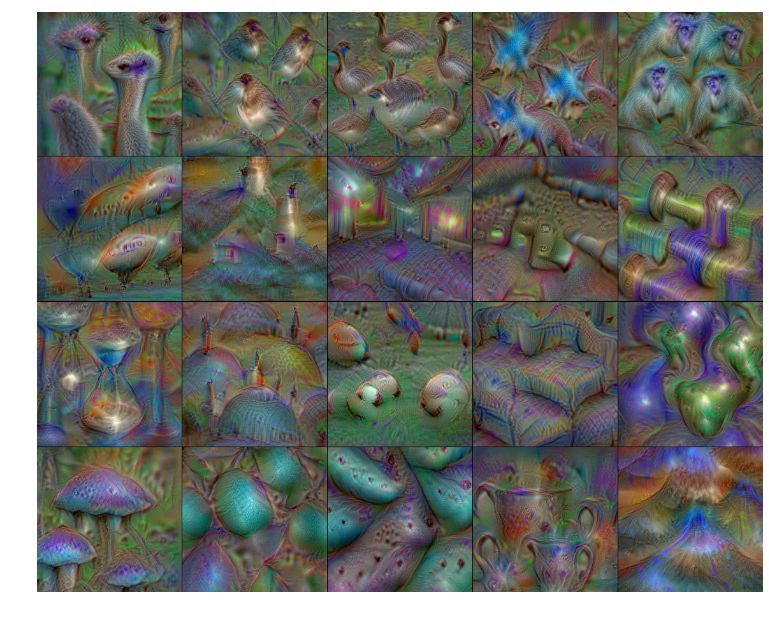

In [20]:
fg = show_filters(images)